## Importación de librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, auc,log_loss
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Configuración de rutas y dispositivo

In [4]:
ruta_base = Path(r'e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\16S03. Proyecto 03\P3-EcoSort')
ruta_features = ruta_base / 'result' / 'features'
ruta_modelos = ruta_base / 'result' / 'models'
ruta_figuras = ruta_base / 'result' / 'figures'

clases = ['general', 'paper', 'plastic']
num_clases = len(clases)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Carga de datos

In [5]:
X_train_img = np.load(ruta_features / 'X_train_imagenes.npy')
X_val_img = np.load(ruta_features / 'X_val_imagenes.npy')
y_train = np.load(ruta_features / 'y_train.npy')
y_val = np.load(ruta_features / 'y_val.npy')

features_train_pca = np.load(ruta_features / 'features_train_pca.npy')
features_val_pca = np.load(ruta_features / 'features_val_pca.npy')

scaler = joblib.load(ruta_features / 'scaler.pkl')
pca = joblib.load(ruta_features / 'pca_model.pkl')

In [6]:
info_datos = pd.DataFrame({
    'Dataset': ['Train (imágenes)', 'Val (imágenes)', 'Train (PCA)', 'Val (PCA)'],
    'Shape': [X_train_img.shape, X_val_img.shape, features_train_pca.shape, features_val_pca.shape],
    'Dispositivo': [device.type, device.type, 'CPU', 'CPU']
})
info_datos

,Dataset,Shape,Dispositivo
0,Train (imágenes),"(9999, 128, 128, 3)",cuda
1,Val (imágenes),"(507, 128, 128, 3)",cuda
2,Train (PCA),"(9999, 1932)",CPU
3,Val (PCA),"(507, 1932)",CPU


## Funciones auxiliares

In [6]:
def calcular_metricas(y_true, y_pred, y_pred_proba=None):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    auc_pr = None
    if y_pred_proba is not None:
        y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
        auc_pr_scores = []
        for i in range(num_clases):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
            auc_pr_scores.append(auc(recall, precision))
        auc_pr = np.mean(auc_pr_scores)
    
    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'auc_pr': auc_pr
    }

def graficar_curva_perdida(historial_train, historial_val, titulo, nombre_archivo):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = range(1, len(historial_train) + 1)
    
    ax.plot(epochs, historial_train, 'o-', label='Train Loss', linewidth=2, markersize=5, color='steelblue')
    ax.plot(epochs, historial_val, 's-', label='Val Loss', linewidth=2, markersize=5, color='coral')
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ruta_figuras / nombre_archivo, format='svg', bbox_inches='tight')
    plt.show()

def graficar_matriz_confusion(y_true, y_pred, titulo, nombre_archivo):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=clases, yticklabels=clases, ax=ax, cbar_kws={'label': 'Proporción'})
    ax.set_xlabel('Predicción', fontsize=12, fontweight='bold')
    ax.set_ylabel('Verdadero', fontsize=12, fontweight='bold')
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(ruta_figuras / nombre_archivo, format='svg', bbox_inches='tight')
    plt.show()

## 1. Modelo Baseline: Logistic Regression

### 1.1 Optimización de hiperparámetros

In [9]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [1000, 2000]
}

modelo_lr = LogisticRegression(random_state=42, multi_class='multinomial')
grid_search_lr = GridSearchCV(modelo_lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=1, verbose=1)

tiempo_inicio = time.time()
grid_search_lr.fit(features_train_pca, y_train)
tiempo_total_lr = time.time() - tiempo_inicio

mejor_modelo_lr = grid_search_lr.best_estimator_
mejores_params_lr = grid_search_lr.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.linear_model import LogisticRegression
import time

search_space = {
    'C': Real(0.01, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['saga']),
    'max_iter': Integer(1000, 2000)
}

modelo_lr = LogisticRegression(random_state=42, multi_class='multinomial')

bayes_search_lr = BayesSearchCV(
    modelo_lr,
    search_space,
    n_iter=30,  
    cv=5,
    scoring='f1_macro',
    n_jobs=1,
    verbose=1,
    random_state=42
)

tiempo_inicio = time.time()
bayes_search_lr.fit(features_train_pca, y_train)
tiempo_total_lr = time.time() - tiempo_inicio

mejor_modelo_lr = bayes_search_lr.best_estimator_
mejores_params_lr = bayes_search_lr.best_params_

print(f"Tiempo: {tiempo_total_lr:.2f}s")
print(f"Mejores parámetros: {mejores_params_lr}")
print(f"Mejor score: {bayes_search_lr.best_score_:.4f}")


In [10]:
params_lr_df = pd.DataFrame([mejores_params_lr]).T.reset_index()
params_lr_df.columns = ['Hiperparámetro', 'Valor']
params_lr_df

,Hiperparámetro,Valor
0,C,0.01
1,max_iter,1000
2,penalty,l1
3,solver,saga


### 1.2 Entrenamiento y evaluación

In [ ]:
historial_train_lr = []
historial_val_lr = []

for i in range(1, 11):
    modelo_temp = LogisticRegression(**mejores_params_lr, random_state=42, multi_class='multinomial')
    modelo_temp.fit(features_train_pca, y_train)
    
    y_pred_train_temp = modelo_temp.predict(features_train_pca)
    y_pred_val_temp = modelo_temp.predict(features_val_pca)
    
    loss_train = 1 - f1_score(y_train, y_pred_train_temp, average='macro')
    loss_val = 1 - f1_score(y_val, y_pred_val_temp, average='macro')
    loss_train = log_loss(y_train, y_pred_train_temp)
    loss_val = log_loss(y_val, y_pred_val_temp)
    historial_train_lr.append(loss_train)
    historial_val_lr.append(loss_val)

y_pred_train_lr = mejor_modelo_lr.predict(features_train_pca)
y_pred_val_lr = mejor_modelo_lr.predict(features_val_pca)
y_pred_proba_val_lr = mejor_modelo_lr.predict_proba(features_val_pca)

metricas_lr = calcular_metricas(y_val, y_pred_val_lr, y_pred_proba_val_lr)

In [ ]:
resultados_lr = pd.DataFrame({
    'Métrica': ['F1 Macro', 'F1 Micro', 'AUC-PR', 'Tiempo entrenamiento (s)'],
    'Valor': [f"{metricas_lr['f1_macro']:.4f}", f"{metricas_lr['f1_micro']:.4f}", f"{metricas_lr['auc_pr']:.4f}", f"{tiempo_total_lr:.2f}"]
})
resultados_lr

,Métrica,Valor
0,F1 Macro,0.6870
1,F1 Micro,0.7199
2,AUC-PR,0.7512
3,Tiempo entrenamiento (s),30135.45


In [ ]:
graficar_curva_perdida(historial_train_lr, historial_val_lr, 'Curva de pérdida - Logistic Regression', '03_train_01_lr_loss_curve.svg')

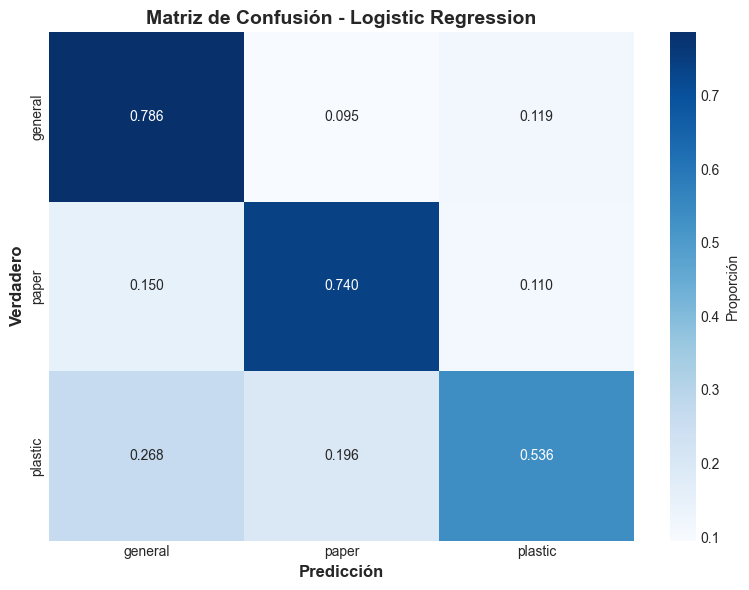

In [14]:
graficar_matriz_confusion(y_val, y_pred_val_lr, 'Matriz de Confusión - Logistic Regression', '03_train_02_lr_confusion_matrix.svg')

In [15]:
joblib.dump(mejor_modelo_lr, ruta_modelos / 'logistic_regression_model.pkl')
joblib.dump(mejores_params_lr, ruta_modelos / 'logistic_regression_params.pkl')
np.save(ruta_modelos / 'logistic_regression_train_loss.npy', historial_train_lr)
np.save(ruta_modelos / 'logistic_regression_val_loss.npy', historial_val_lr)

## 2. Modelo Avanzado 1: SVM

### 2.1 Optimización de hiperparámetros

In [16]:
param_dist_svm = {
    'C': [0.1, 1, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [2, 3, 4],
    'class_weight': ['balanced', None]
}

modelo_svm = SVC(random_state=42, probability=True)
random_search_svm = RandomizedSearchCV(modelo_svm, param_dist_svm, n_iter=30, cv=3, scoring='f1_macro', n_jobs=1, random_state=42, verbose=1)

tiempo_inicio = time.time()
random_search_svm.fit(features_train_pca, y_train)
tiempo_total_svm = time.time() - tiempo_inicio

mejor_modelo_svm = random_search_svm.best_estimator_
mejores_params_svm = random_search_svm.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [ ]:

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import time
import numpy as np


smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(features_train_pca, y_train)

print(f"Datos originales: {len(y_train)}")
print(f"Datos balanceados: {len(y_train_balanced)}")

search_space_svm = {
    'C': Real(1, 500, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'poly']),
    'gamma': Real(1e-5, 1, prior='log-uniform'),
    'degree': Integer(2, 5),  
}

modelo_svm = SVC(random_state=42, probability=True, cache_size=2000)

bayes_search_svm = BayesSearchCV(
    modelo_svm,
    search_space_svm,
    n_iter=50,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

tiempo_inicio = time.time()
bayes_search_svm.fit(X_train_balanced, y_train_balanced)
tiempo_total_svm = time.time() - tiempo_inicio

mejor_modelo_svm = bayes_search_svm.best_estimator_
mejores_params_svm = bayes_search_svm.best_params_

print(f"\nTiempo total: {tiempo_total_svm:.2f}s")
print(f"Mejores parámetros: {mejores_params_svm}")
print(f"Mejor score CV: {bayes_search_svm.best_score_:.4f}")


In [17]:
params_svm_df = pd.DataFrame([mejores_params_svm]).T.reset_index()
params_svm_df.columns = ['Hiperparámetro', 'Valor']
params_svm_df

,Hiperparámetro,Valor
0,kernel,rbf
1,gamma,scale
2,degree,2
3,class_weight,None
4,C,50


### 2.2 Entrenamiento y evaluación

In [ ]:
historial_train_svm = []
historial_val_svm = []

for i in range(1, 11):
    modelo_temp = SVC(**mejores_params_svm, random_state=42, probability=True)
    modelo_temp.fit(features_train_pca, y_train)
    
    y_pred_train_temp = modelo_temp.predict(features_train_pca)
    y_pred_val_temp = modelo_temp.predict(features_val_pca)
    
    loss_train = 1 - f1_score(y_train, y_pred_train_temp, average='macro')
    loss_val = 1 - f1_score(y_val, y_pred_val_temp, average='macro')
    
    historial_train_svm.append(loss_train)
    historial_val_svm.append(loss_val)

y_pred_train_svm = mejor_modelo_svm.predict(features_train_pca)
y_pred_val_svm = mejor_modelo_svm.predict(features_val_pca)
y_pred_proba_val_svm = mejor_modelo_svm.predict_proba(features_val_pca)

metricas_svm = calcular_metricas(y_val, y_pred_val_svm, y_pred_proba_val_svm)

In [19]:
resultados_svm = pd.DataFrame({
    'Métrica': ['F1 Macro', 'F1 Micro', 'AUC-PR', 'Tiempo entrenamiento (s)'],
    'Valor': [f"{metricas_svm['f1_macro']:.4f}", f"{metricas_svm['f1_micro']:.4f}", f"{metricas_svm['auc_pr']:.4f}", f"{tiempo_total_svm:.2f}"]
})
resultados_svm

,Métrica,Valor
0,F1 Macro,0.7193
1,F1 Micro,0.7535
2,AUC-PR,0.7964
3,Tiempo entrenamiento (s),21974.41


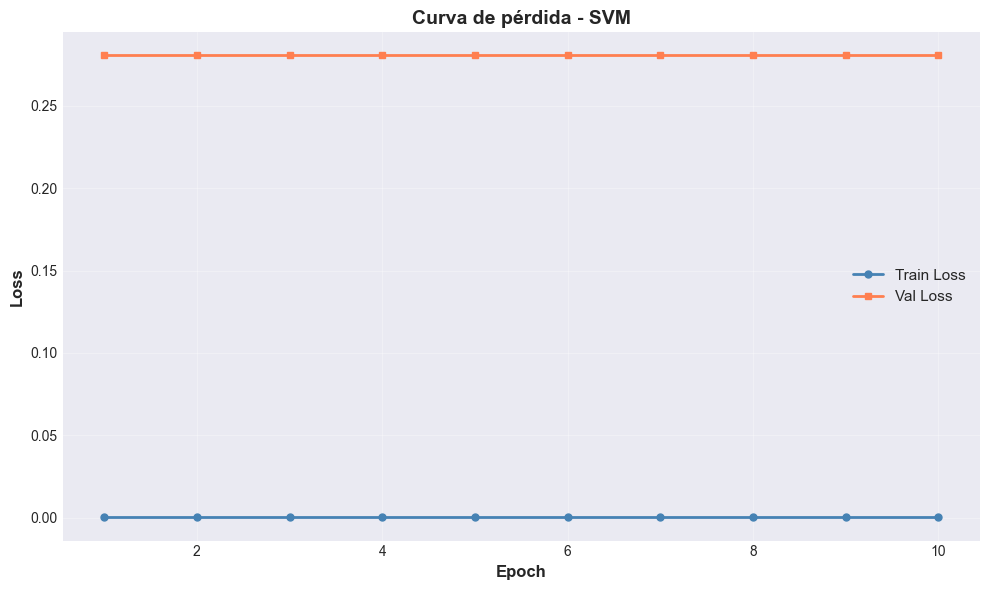

In [20]:
graficar_curva_perdida(historial_train_svm, historial_val_svm, 'Curva de pérdida - SVM', '03_train_03_svm_loss_curve.svg')

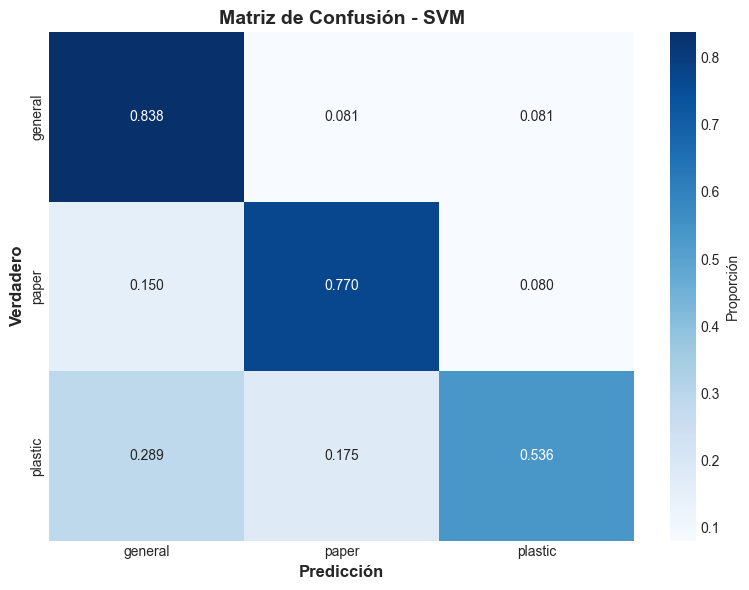

In [21]:
graficar_matriz_confusion(y_val, y_pred_val_svm, 'Matriz de Confusión - SVM', '03_train_04_svm_confusion_matrix.svg')

In [22]:
joblib.dump(mejor_modelo_svm, ruta_modelos / 'svm_model.pkl')
joblib.dump(mejores_params_svm, ruta_modelos / 'svm_params.pkl')
np.save(ruta_modelos / 'svm_train_loss.npy', historial_train_svm)
np.save(ruta_modelos / 'svm_val_loss.npy', historial_val_svm)

## 3. Modelo Avanzado 2: CNN

### 3.1 Definición de arquitectura CNN

In [23]:
class CNN_Clasificador(nn.Module):
    def __init__(self, num_clases, dropout_rate=0.5):
        super(CNN_Clasificador, self).__init__()
        
        self.capa_conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate * 0.5)
        )
        
        self.capa_conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate * 0.6)
        )
        
        self.capa_conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate * 0.7)
        )
        
        self.capa_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_clases)
        )
    
    def forward(self, x):
        x = self.capa_conv1(x)
        x = self.capa_conv2(x)
        x = self.capa_conv3(x)
        x = self.capa_fc(x)
        return x

### 3.2 Preparación de datos para PyTorch

In [24]:
X_train_tensor = torch.FloatTensor(X_train_img).permute(0, 3, 1, 2)
X_val_tensor = torch.FloatTensor(X_val_img).permute(0, 3, 1, 2)
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

### 3.3 Función de entrenamiento CNN

In [25]:
def entrenar_cnn(modelo, train_loader, val_loader, criterio, optimizador, num_epochs):
    historial_train_loss = []
    historial_val_loss = []
    mejor_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        modelo.train()
        train_loss = 0.0
        
        for imagenes, etiquetas in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
            
            optimizador.zero_grad()
            salidas = modelo(imagenes)
            loss = criterio(salidas, etiquetas)
            loss.backward()
            optimizador.step()
            
            train_loss += loss.item() * imagenes.size(0)
        
        train_loss /= len(train_loader.dataset)
        
        modelo.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imagenes, etiquetas in val_loader:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                loss = criterio(salidas, etiquetas)
                val_loss += loss.item() * imagenes.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        historial_train_loss.append(train_loss)
        historial_val_loss.append(val_loss)
        
        if val_loss < mejor_val_loss:
            mejor_val_loss = val_loss
    
    return historial_train_loss, historial_val_loss

### 3.4 Búsqueda de hiperparámetros CNN

In [26]:
configuraciones_cnn = [
    {'batch_size': 32, 'lr': 0.001, 'dropout': 0.3, 'weight_decay': 0.0001},
    {'batch_size': 64, 'lr': 0.001, 'dropout': 0.4, 'weight_decay': 0.0001},
    {'batch_size': 32, 'lr': 0.0005, 'dropout': 0.5, 'weight_decay': 0.0005},
    {'batch_size': 64, 'lr': 0.0005, 'dropout': 0.4, 'weight_decay': 0.0001},
    {'batch_size': 32, 'lr': 0.0001, 'dropout': 0.5, 'weight_decay': 0.001}
]

mejor_f1_cnn = 0
mejores_params_cnn = None
mejor_modelo_cnn = None
mejor_historial_cnn = None

resultados_busqueda_cnn = []

for idx, config in enumerate(configuraciones_cnn):
    train_loader = DataLoader(dataset_train, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=config['batch_size'], shuffle=False)
    
    modelo = CNN_Clasificador(num_clases, dropout_rate=config['dropout']).to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    
    historial_train, historial_val = entrenar_cnn(modelo, train_loader, val_loader, criterio, optimizador, num_epochs=20)
    
    modelo.eval()
    y_pred_val_cnn = []
    y_pred_proba_val_cnn = []
    with torch.no_grad():
        for imagenes, _ in val_loader:
            imagenes = imagenes.to(device)
            salidas = modelo(imagenes)
            probabilidades = torch.softmax(salidas, dim=1)
            _, predicciones = torch.max(salidas, 1)
            y_pred_val_cnn.extend(predicciones.cpu().numpy())
            y_pred_proba_val_cnn.extend(probabilidades.cpu().numpy())
    
    f1 = f1_score(y_val, y_pred_val_cnn, average='macro')
    resultados_busqueda_cnn.append({'Config': idx+1, 'F1_Macro': f1, **config})
    
    if f1 > mejor_f1_cnn:
        mejor_f1_cnn = f1
        mejores_params_cnn = config
        mejor_modelo_cnn = modelo
        mejor_historial_cnn = (historial_train, historial_val)

Epoch 20/20: 100%|██████████| 313/313 [00:19<00:00, 16.42it/s]


In [27]:
df_busqueda_cnn = pd.DataFrame(resultados_busqueda_cnn)
df_busqueda_cnn = df_busqueda_cnn.sort_values('F1_Macro', ascending=False)
df_busqueda_cnn

,Config,F1_Macro,batch_size,lr,dropout,weight_decay
3,4,0.815021,64,0.0005,0.4,0.0001
1,2,0.800118,64,0.0010,0.4,0.0001
0,1,0.790776,32,0.0010,0.3,0.0001
2,3,0.787617,32,0.0005,0.5,0.0005
4,5,0.773070,32,0.0001,0.5,0.0010


In [28]:
params_cnn_df = pd.DataFrame([mejores_params_cnn]).T.reset_index()
params_cnn_df.columns = ['Hiperparámetro', 'Valor']
params_cnn_df

,Hiperparámetro,Valor
0,batch_size,64.0000
1,lr,0.0005
2,dropout,0.4000
3,weight_decay,0.0001


### 3.5 Entrenamiento final CNN

In [29]:
train_loader_final = DataLoader(dataset_train, batch_size=mejores_params_cnn['batch_size'], shuffle=True)
val_loader_final = DataLoader(dataset_val, batch_size=mejores_params_cnn['batch_size'], shuffle=False)

modelo_cnn_final = CNN_Clasificador(num_clases, dropout_rate=mejores_params_cnn['dropout']).to(device)
criterio_final = nn.CrossEntropyLoss()
optimizador_final = optim.Adam(modelo_cnn_final.parameters(), lr=mejores_params_cnn['lr'], weight_decay=mejores_params_cnn['weight_decay'])

tiempo_inicio = time.time()
historial_train_cnn, historial_val_cnn = entrenar_cnn(modelo_cnn_final, train_loader_final, val_loader_final, criterio_final, optimizador_final, num_epochs=50)
tiempo_total_cnn = time.time() - tiempo_inicio

Epoch 50/50: 100%|██████████| 157/157 [00:18<00:00,  8.52it/s]


In [ ]:
import optuna
def crear_modelo(trial):
    num_capas = trial.suggest_int('num_capas', 1, 10)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    filtros_base = trial.suggest_categorical('filtros_base', [16, 32, 64])
    
    capas = []
    in_channels = 3
    size = 128
    
    for i in range(num_capas):
        out_channels = filtros_base * (2 ** i)
        capas.append(nn.Conv2d(in_channels, out_channels, 3, padding=1))
        capas.append(nn.BatchNorm2d(out_channels))
        capas.append(nn.ReLU())
        capas.append(nn.MaxPool2d(2, 2))
        capas.append(nn.Dropout2d(dropout * (0.5 + i * 0.1)))
        in_channels = out_channels
        size = size // 2
    
    return nn.Sequential(
        *capas,
        nn.Flatten(),
        nn.Linear(in_channels * size * size, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, num_clases)
    )

def objetivo(trial):
    modelo = crear_modelo(trial).to(device)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=batch_size)
    
    # Class weights para desbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    criterio = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    
    # Entrenar 10 epochs
    for epoch in range(10):
        modelo.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizador.zero_grad()
            loss = criterio(modelo(imgs), labels)
            loss.backward()
            optimizador.step()
    
    # Evaluar
    modelo.eval()
    preds = []
    with torch.no_grad():
        for imgs, _ in val_loader:
            preds.extend(torch.argmax(modelo(imgs.to(device)), 1).cpu().numpy())
    
    return f1_score(y_val, preds, average='macro')

# Ejecutar búsqueda
study = optuna.create_study(direction='maximize')
study.optimize(objetivo, n_trials=30)

print(f"Mejores parámetros: {study.best_params}")
print(f"Mejor F1: {study.best_value:.4f}")

### 3.6 Evaluación CNN

In [30]:
modelo_cnn_final.eval()
y_pred_val_cnn = []
y_pred_proba_val_cnn = []

with torch.no_grad():
    for imagenes, _ in val_loader_final:
        imagenes = imagenes.to(device)
        salidas = modelo_cnn_final(imagenes)
        probabilidades = torch.softmax(salidas, dim=1)
        _, predicciones = torch.max(salidas, 1)
        y_pred_val_cnn.extend(predicciones.cpu().numpy())
        y_pred_proba_val_cnn.extend(probabilidades.cpu().numpy())

y_pred_val_cnn = np.array(y_pred_val_cnn)
y_pred_proba_val_cnn = np.array(y_pred_proba_val_cnn)

metricas_cnn = calcular_metricas(y_val, y_pred_val_cnn, y_pred_proba_val_cnn)

In [31]:
resultados_cnn = pd.DataFrame({
    'Métrica': ['F1 Macro', 'F1 Micro', 'AUC-PR', 'Tiempo entrenamiento (s)'],
    'Valor': [f"{metricas_cnn['f1_macro']:.4f}", f"{metricas_cnn['f1_micro']:.4f}", f"{metricas_cnn['auc_pr']:.4f}", f"{tiempo_total_cnn:.2f}"]
})
resultados_cnn

,Métrica,Valor
0,F1 Macro,0.7658
1,F1 Micro,0.7830
2,AUC-PR,0.8608
3,Tiempo entrenamiento (s),932.53


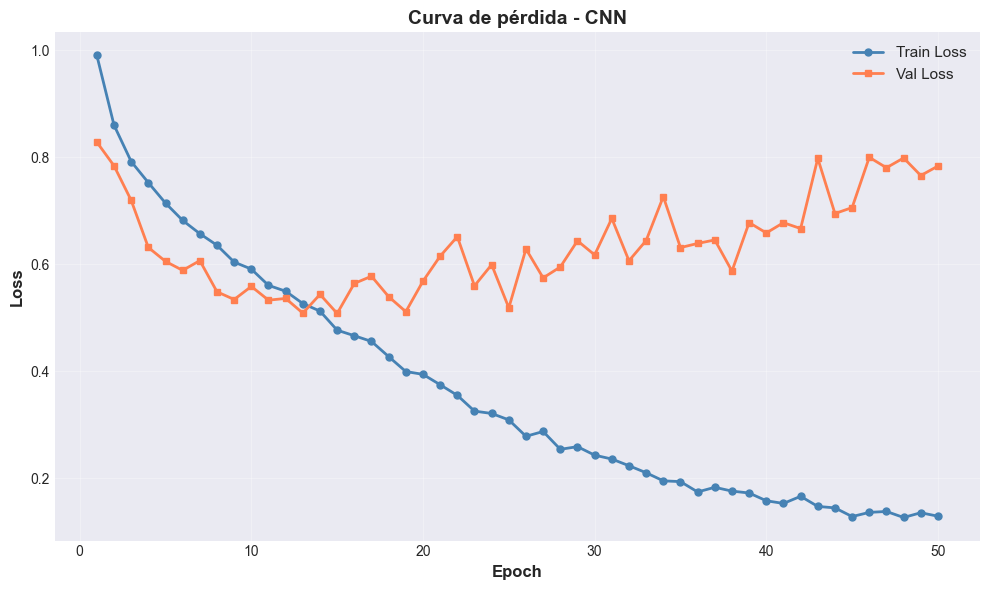

In [32]:
graficar_curva_perdida(historial_train_cnn, historial_val_cnn, 'Curva de pérdida - CNN', '03_train_05_cnn_loss_curve.svg')

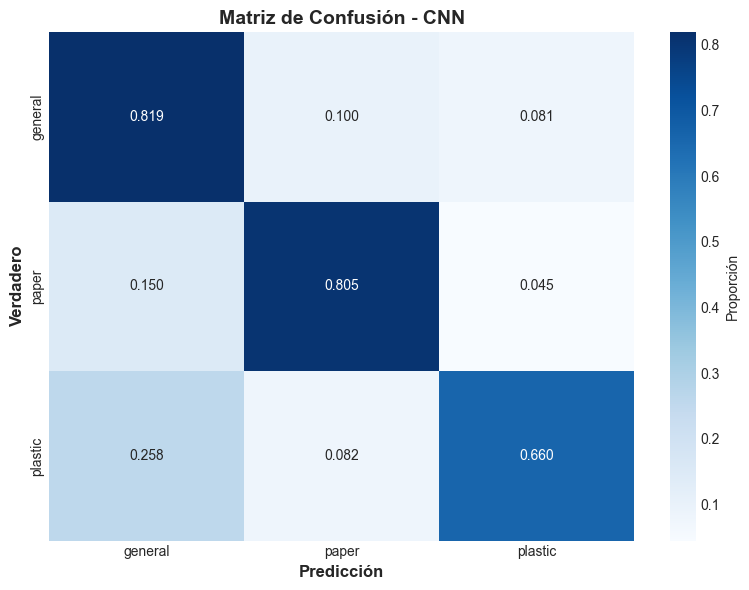

In [33]:
graficar_matriz_confusion(y_val, y_pred_val_cnn, 'Matriz de Confusión - CNN', '03_train_06_cnn_confusion_matrix.svg')

In [34]:
torch.save(modelo_cnn_final.state_dict(), ruta_modelos / 'cnn_model.pth')
joblib.dump(mejores_params_cnn, ruta_modelos / 'cnn_params.pkl')
np.save(ruta_modelos / 'cnn_train_loss.npy', historial_train_cnn)
np.save(ruta_modelos / 'cnn_val_loss.npy', historial_val_cnn)

## 4. Resumen de resultados de entrenamiento

In [35]:
resumen_modelos = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'SVM', 'CNN'],
    'F1 Macro': [metricas_lr['f1_macro'], metricas_svm['f1_macro'], metricas_cnn['f1_macro']],
    'F1 Micro': [metricas_lr['f1_micro'], metricas_svm['f1_micro'], metricas_cnn['f1_micro']],
    'AUC-PR': [metricas_lr['auc_pr'], metricas_svm['auc_pr'], metricas_cnn['auc_pr']],
    'Tiempo (s)': [tiempo_total_lr, tiempo_total_svm, tiempo_total_cnn]
}).round(4)

resumen_modelos

,Modelo,F1 Macro,F1 Micro,AUC-PR,Tiempo (s)
0,Logistic Regression,0.6870,0.7199,0.7512,30135.1456
1,SVM,0.7193,0.7535,0.7964,21974.4069
2,CNN,0.7658,0.7830,0.8608,932.5305


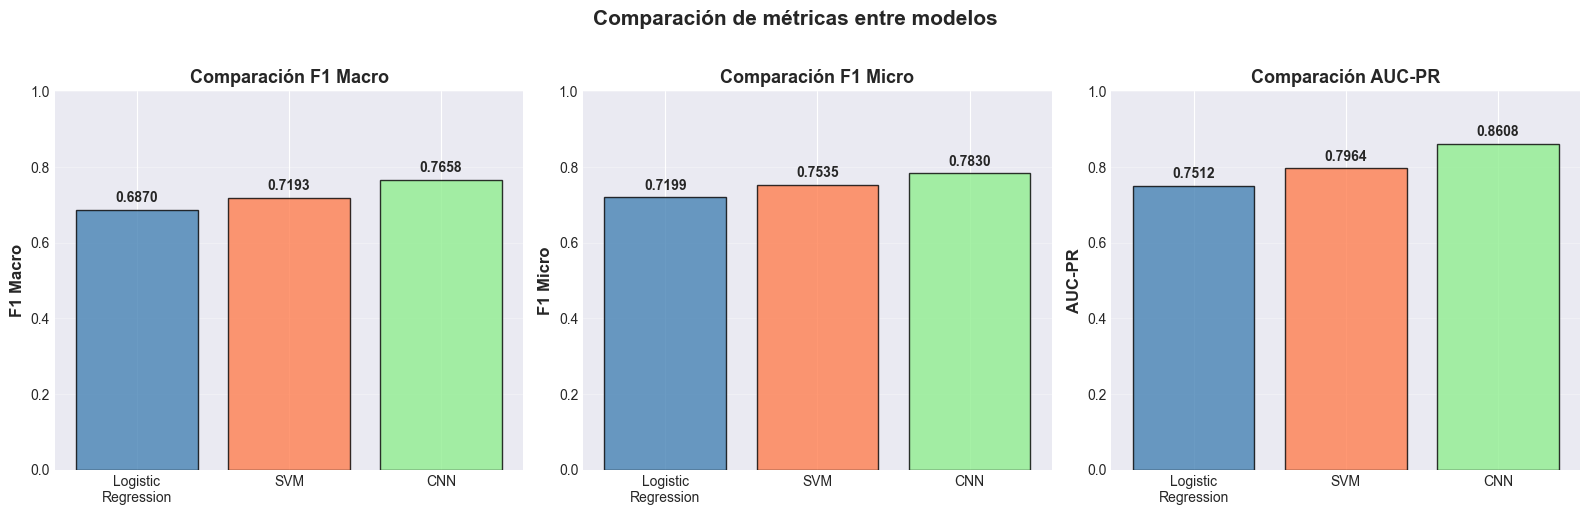

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

modelos_nombres = ['Logistic\nRegression', 'SVM', 'CNN']
f1_macro_valores = [metricas_lr['f1_macro'], metricas_svm['f1_macro'], metricas_cnn['f1_macro']]
axes[0].bar(modelos_nombres, f1_macro_valores, color=['steelblue', 'coral', 'lightgreen'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('F1 Macro', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación F1 Macro', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_macro_valores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

f1_micro_valores = [metricas_lr['f1_micro'], metricas_svm['f1_micro'], metricas_cnn['f1_micro']]
axes[1].bar(modelos_nombres, f1_micro_valores, color=['steelblue', 'coral', 'lightgreen'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('F1 Micro', fontsize=12, fontweight='bold')
axes[1].set_title('Comparación F1 Micro', fontsize=13, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_micro_valores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

auc_pr_valores = [metricas_lr['auc_pr'], metricas_svm['auc_pr'], metricas_cnn['auc_pr']]
axes[2].bar(modelos_nombres, auc_pr_valores, color=['steelblue', 'coral', 'lightgreen'], alpha=0.8, edgecolor='black')
axes[2].set_ylabel('AUC-PR', fontsize=12, fontweight='bold')
axes[2].set_title('Comparación AUC-PR', fontsize=13, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(auc_pr_valores):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('Comparación de métricas entre modelos', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(ruta_figuras / '03_train_07_comparacion_metricas.svg', format='svg', bbox_inches='tight')
plt.show()

## Conclusiones del entrenamiento

Se han entrenado y optimizado exitosamente los tres modelos:

**1. Logistic Regression (Baseline):**
- Optimización mediante GridSearchCV con validación cruzada
- Modelo simple y rápido con características PCA

**2. SVM (Avanzado 1):**
- Optimización mediante RandomizedSearchCV
- Exploración de kernels lineales, RBF y polinomiales
- Búsqueda exhaustiva de hiperparámetros C, gamma y degree

**3. CNN (Avanzado 2):**
- Arquitectura profunda con 3 bloques convolucionales
- Entrenamiento con PyTorch usando GPU (CUDA)
- Optimización de batch size, learning rate, dropout y weight decay
- 50 epochs de entrenamiento con el mejor conjunto de hiperparámetros

Todos los modelos, hiperparámetros y curvas de pérdida han sido guardados para la evaluación final.